In [1]:
# Instalar pacotes (se necessário)
%pip install boto3
%pip install pandas
%pip install matplotlib
%pip install pyspark

# Importar bibliotecas
import boto3
import pandas as pd
import matplotlib.pyplot as plt
import io
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, year, month, dayofmonth, when, current_date, to_date
import pyspark.sql.functions as F

# Inicializar Spark
spark = SparkSession.builder.appName("AnaliseUPA").getOrCreate()
spark.conf.set("spark.sql.session.timeZone", "America/Sao_Paulo")

# Nome do bucket e arquivos
BUCKET_NAME = 'bucket-trusted-upa-connect-mateus'
PACIENTE_KEY = 'paciente.csv'
BIOMETRIA_KEY = 'biometria.csv'

# Cliente S3
s3 = boto3.client('s3')

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/29 00:48:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/usr/local/lib/python3.7/site-packages/pyspark/context.py:317: FutureWarning: Python 3.7 support is deprecated in Spark 3.4.
  warnings.warn("Python 3.7 support is deprecated in Spark 3.4.", FutureWarning)
/usr/local/lib/python3.7/site-packages/boto3/compat.py:82: PythonDeprecationWarning: Boto3 will no longer support Python 3.7 starting December 13, 2023. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.8 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [2]:
# Ler paciente.csv
obj_paciente = s3.get_object(Bucket=BUCKET_NAME, Key=PACIENTE_KEY)
paciente_pd = pd.read_csv(io.BytesIO(obj_paciente['Body'].read()))

# Ler biometria.csv
obj_biometria = s3.get_object(Bucket=BUCKET_NAME, Key=BIOMETRIA_KEY)
biometria_pd = pd.read_csv(io.BytesIO(obj_biometria['Body'].read()))

In [3]:
# Transformar em DataFrame Spark
paciente_df = spark.createDataFrame(paciente_pd)
biometria_df = spark.createDataFrame(biometria_pd)

In [4]:
# Filtrar pacientes da UPA 1
paciente_df = paciente_df.filter(col("fk_upa") == 1)

In [5]:
# Juntar paciente e biometria
df = biometria_df.join(paciente_df, biometria_df.fk_paciente == paciente_df.id_paciente, "inner") \
    .select(paciente_df.data_nascimento.alias("DataNascimento"),
            biometria_df.data_hora.alias("DataHora"))

# Filtrar registros do dia atual
df = df.filter(to_date("DataHora") == current_date())

spark.sql("SELECT current_date() AS data_hoje").show()

+----------+
| data_hoje|
+----------+
|2025-04-28|
+----------+



In [6]:
# Converter para timestamp
df = df.withColumn("DataNascimento", col("DataNascimento").cast("timestamp"))
df = df.withColumn("DataHora", col("DataHora").cast("timestamp"))

# Calcular idade
df = df.withColumn("AnoNascimento", year(col("DataNascimento")))
df = df.withColumn("AnoAtendimento", year(col("DataHora")))
df = df.withColumn("Idade", col("AnoAtendimento") - col("AnoNascimento"))

# Corrigir idade para quem ainda não fez aniversário
df = df.withColumn("Aniversario_Passou", 
    (month(col("DataHora")) > month(col("DataNascimento"))) | 
    ((month(col("DataHora")) == month(col("DataNascimento"))) & (dayofmonth(col("DataHora")) >= dayofmonth(col("DataNascimento"))))
)
df = df.withColumn("IdadeCorrigida", 
    when(col("Aniversario_Passou") == False, col("Idade") - 1).otherwise(col("Idade"))
)


In [7]:
# Criar faixas etárias
df = df.withColumn("Faixa_Etaria", when((col("IdadeCorrigida") >= 0) & (col("IdadeCorrigida") <= 12), "0–12")
                                  .when((col("IdadeCorrigida") >= 13) & (col("IdadeCorrigida") <= 17), "13–17")
                                  .when((col("IdadeCorrigida") >= 18) & (col("IdadeCorrigida") <= 39), "18–39")
                                  .when((col("IdadeCorrigida") >= 40) & (col("IdadeCorrigida") <= 59), "40–59")
                                  .otherwise("60+"))

# Criar faixa de horários
df = df.withColumn("Hora", F.hour(col("DataHora")))
df = df.withColumn("Faixa_Hora", when((col("Hora") >= 0) & (col("Hora") < 6), "0–6h")
                                 .when((col("Hora") >= 6) & (col("Hora") < 9), "6–9h")
                                 .when((col("Hora") >= 9) & (col("Hora") < 12), "9–12h")
                                 .when((col("Hora") >= 12) & (col("Hora") < 15), "12–15h")
                                 .when((col("Hora") >= 15) & (col("Hora") < 18), "15–18h")
                                 .when((col("Hora") >= 18) & (col("Hora") < 21), "18–21h")
                                 .otherwise("21–24h"))

In [8]:
# Agrupar os dados
resultado = df.groupBy("Faixa_Hora", "Faixa_Etaria").count()

# Transformar para Pandas para plotar
resultado_pandas = resultado.toPandas()

# Pivotar a tabela
tabela = resultado_pandas.pivot(index='Faixa_Hora', columns='Faixa_Etaria', values='count').fillna(0)

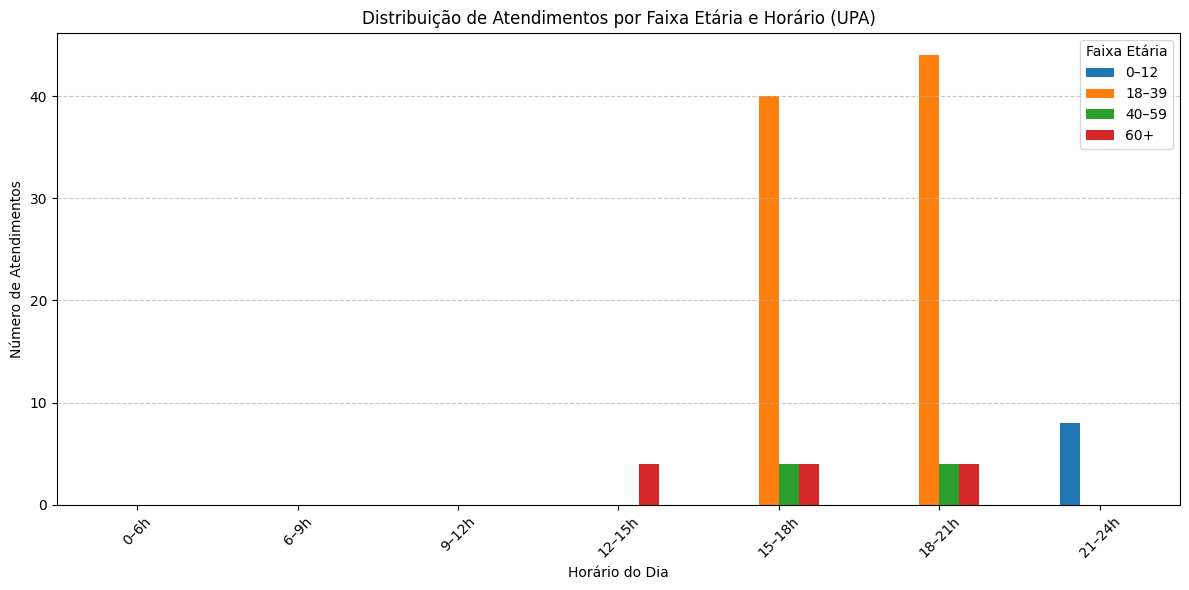

In [9]:
# Definir faixas fixas
faixas_horario = ['0–6h', '6–9h', '9–12h', '12–15h', '15–18h', '18–21h', '21–24h']

# Reindexar para garantir todas as faixas, mesmo sem dados
tabela = tabela.reindex(faixas_horario, fill_value=0)

# Plotar o gráfico se houver dados
if not tabela.empty:
    tabela.plot(kind='bar', figsize=(12, 6))
    plt.title("Distribuição de Atendimentos por Faixa Etária e Horário (UPA)")
    plt.xlabel("Horário do Dia")
    plt.ylabel("Número de Atendimentos")
    plt.legend(title="Faixa Etária")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("Nenhum atendimento registrado hoje.")